In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, GRU, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-9-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-10-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [12]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# GRU1

In [41]:
# Model 1
model = Sequential()
model.add(GRU(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 128)               53376     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 70275 (274.51 KB)
Trainable params: 70275 (274.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 3s 31ms/step - loss: 1.0732 - accuracy: 0.4286 - val_loss: 1.0271 - val_accuracy: 0.4868
Epoch 2/10
26/26 [==============================] - 0s 12ms/step - loss: 0.9847 - accuracy: 0.5026 - val_loss: 0.8987 - val_accuracy: 0.5994
Epoch 3/10
26/26 [==============================] - 0s 11ms/step - loss: 0.8653 - accuracy: 0.5912 - val_loss: 0.7789 - val_accuracy: 0.6410
Epoch 4/10
26/26 [==============================] - 0s 14ms/step - loss: 0.6910 - accuracy: 0.6919 - val_loss: 0.5549 - val_accuracy: 0.7769
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.3953 - accuracy: 0.8575 - val_loss: 0.1501 - val_accuracy: 0.9574
Epoch 6/10
26/26 [==============================] - 0s 12ms/step - loss: 0.1716 - accuracy: 0.9479 - val_loss: 0.1956 - val_accuracy: 0.9554
Epoch 7/10
26/26 [==============================] - 0s 13ms/step - loss: 0.1421 - accuracy: 0.9629 - val_loss: 0.0697 - val_accuracy: 0.9878
Epoch 8/10
26

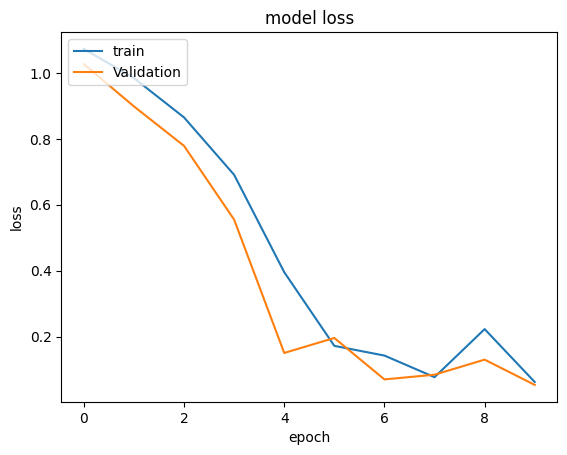

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

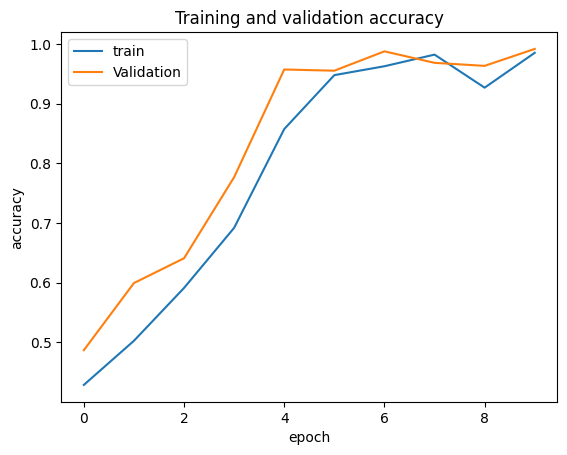

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 4ms/step
[[463  11  22]
 [ 23 429  19]
 [  8   1 411]]
0.93943763518385
0.9394121318192338
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       496
           1       0.97      0.91      0.94       471
           2       0.91      0.98      0.94       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

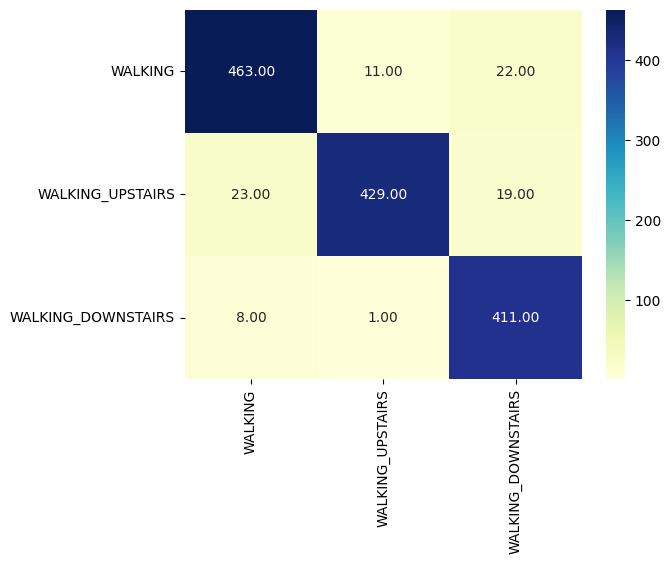

In [45]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 2


In [46]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_16 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_17 (GRU)                (None, 128)               99072     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                                 
Total params: 169347 (661.51 KB)
Trainable params: 169

In [47]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 5s 52ms/step - loss: 1.0701 - accuracy: 0.4161 - val_loss: 0.9999 - val_accuracy: 0.5172
Epoch 2/10
26/26 [==============================] - 1s 20ms/step - loss: 0.9425 - accuracy: 0.5437 - val_loss: 0.8412 - val_accuracy: 0.6075
Epoch 3/10
26/26 [==============================] - 0s 19ms/step - loss: 0.8143 - accuracy: 0.6155 - val_loss: 0.6833 - val_accuracy: 0.6856
Epoch 4/10
26/26 [==============================] - 1s 19ms/step - loss: 0.5367 - accuracy: 0.7677 - val_loss: 0.2972 - val_accuracy: 0.8702
Epoch 5/10
26/26 [==============================] - 0s 19ms/step - loss: 0.2330 - accuracy: 0.9126 - val_loss: 0.0902 - val_accuracy: 0.9706
Epoch 6/10
26/26 [==============================] - 0s 19ms/step - loss: 0.0862 - accuracy: 0.9726 - val_loss: 0.1547 - val_accuracy: 0.9442
Epoch 7/10
26/26 [==============================] - 0s 19ms/step - loss: 0.0624 - accuracy: 0.9814 - val_loss: 0.0794 - val_accuracy: 0.9767
Epoch 8/10
26

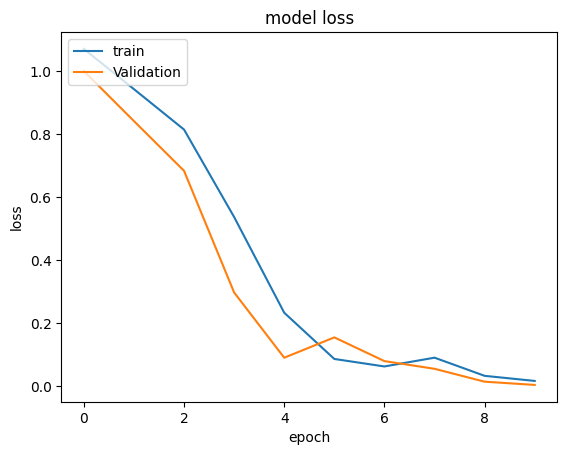

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

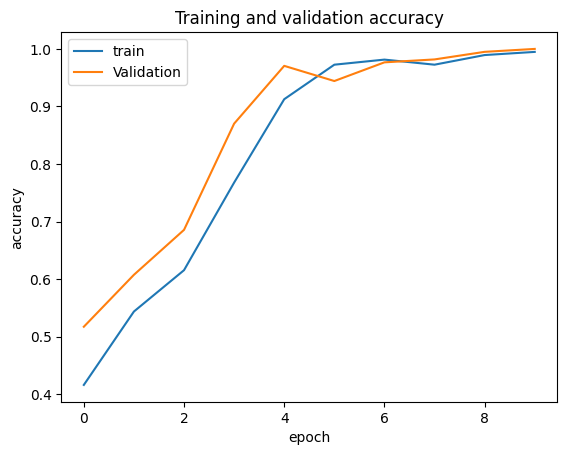

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 7ms/step
[[489   5   2]
 [ 16 455   0]
 [  3   8 409]]
0.9754866618601298
0.9755145317199337
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       496
           1       0.97      0.97      0.97       471
           2       1.00      0.97      0.98       420

    accuracy                           0.98      1387
   macro avg       0.98      0.98      0.98      1387
weighted avg       0.98      0.98      0.98      1387



<Axes: >

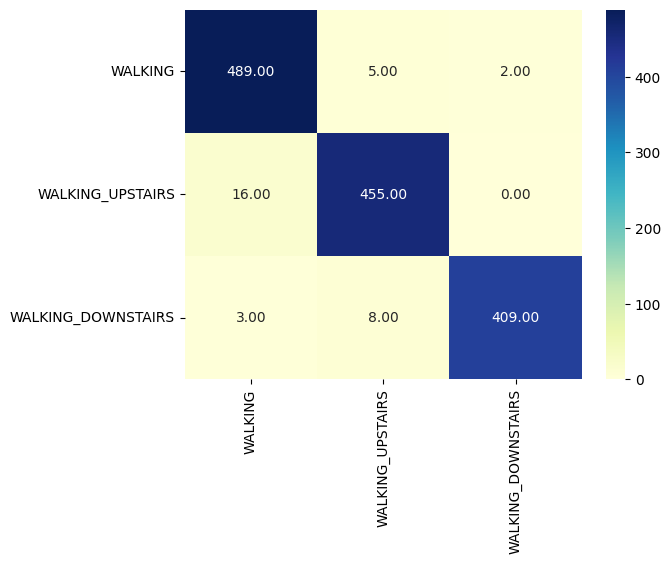

In [50]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 3

In [51]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_18 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_19 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_19 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_20 (GRU)                (None, 128)               99072     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [52]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 7s 75ms/step - loss: 1.0743 - accuracy: 0.4216 - val_loss: 0.9913 - val_accuracy: 0.5304
Epoch 2/10
26/26 [==============================] - 1s 31ms/step - loss: 0.9282 - accuracy: 0.5510 - val_loss: 0.7954 - val_accuracy: 0.6065
Epoch 3/10
26/26 [==============================] - 1s 30ms/step - loss: 0.7926 - accuracy: 0.6387 - val_loss: 0.6424 - val_accuracy: 0.7089
Epoch 4/10
26/26 [==============================] - 1s 29ms/step - loss: 0.5089 - accuracy: 0.7921 - val_loss: 0.3091 - val_accuracy: 0.8945
Epoch 5/10
26/26 [==============================] - 1s 32ms/step - loss: 0.1916 - accuracy: 0.9419 - val_loss: 0.1411 - val_accuracy: 0.9523
Epoch 6/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0881 - accuracy: 0.9732 - val_loss: 0.0351 - val_accuracy: 0.9848
Epoch 7/10
26/26 [==============================] - 1s 28ms/step - loss: 0.0440 - accuracy: 0.9872 - val_loss: 0.0170 - val_accuracy: 0.9970
Epoch 8/10
26

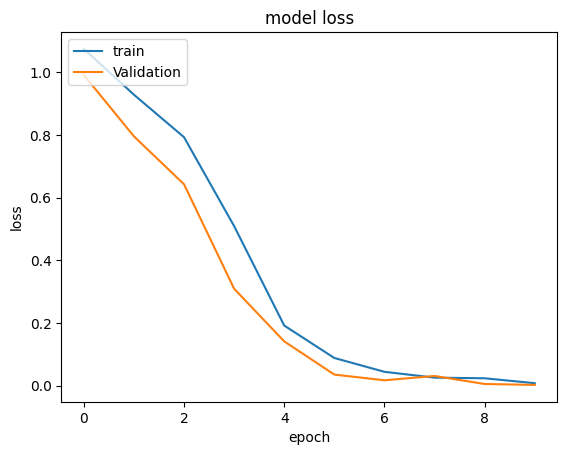

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

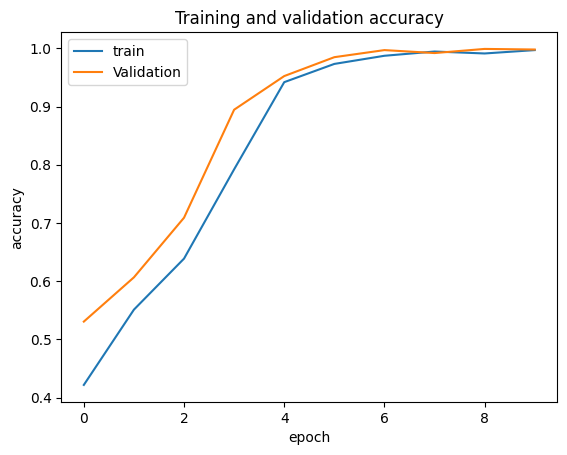

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 10ms/step
[[474  14   8]
 [ 20 430  21]
 [  0   2 418]]
0.9531362653208363
0.9528935000246045
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       496
           1       0.96      0.91      0.94       471
           2       0.94      1.00      0.96       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

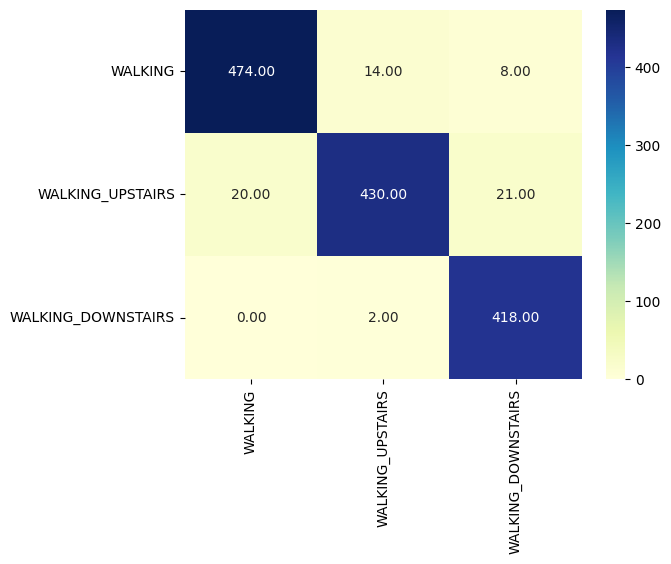

In [55]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 4

In [56]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_21 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_21 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_22 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_22 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_23 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_23 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_24 (GRU)                (None, 128)              

In [57]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 10s 86ms/step - loss: 1.0815 - accuracy: 0.4018 - val_loss: 0.9951 - val_accuracy: 0.5091
Epoch 2/10
26/26 [==============================] - 1s 37ms/step - loss: 0.9600 - accuracy: 0.5294 - val_loss: 0.8847 - val_accuracy: 0.5680
Epoch 3/10
26/26 [==============================] - 1s 37ms/step - loss: 0.8109 - accuracy: 0.6140 - val_loss: 0.5964 - val_accuracy: 0.7383
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.5020 - accuracy: 0.8033 - val_loss: 0.3494 - val_accuracy: 0.8854
Epoch 5/10
26/26 [==============================] - 1s 37ms/step - loss: 0.1929 - accuracy: 0.9403 - val_loss: 0.1445 - val_accuracy: 0.9483
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0999 - accuracy: 0.9711 - val_loss: 0.0469 - val_accuracy: 0.9868
Epoch 7/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0581 - accuracy: 0.9854 - val_loss: 0.0332 - val_accuracy: 0.9909
Epoch 8/10
2

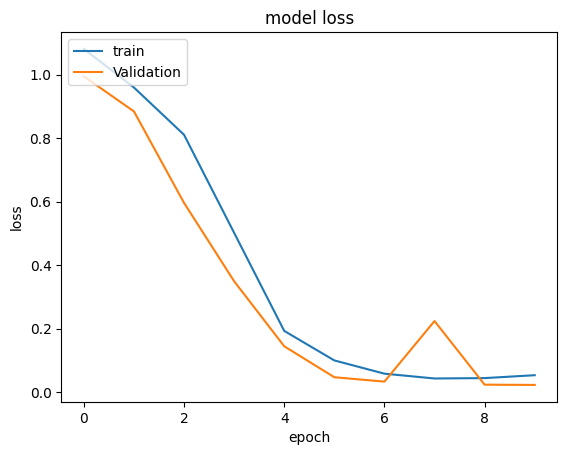

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

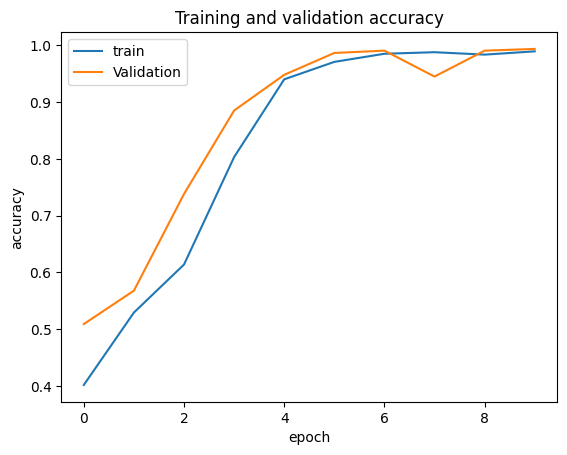

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 13ms/step
[[456  10  30]
 [  6 452  13]
 [  5   7 408]]
0.9488103821196827
0.9489347868788739
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.96      0.96      0.96       471
           2       0.90      0.97      0.94       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

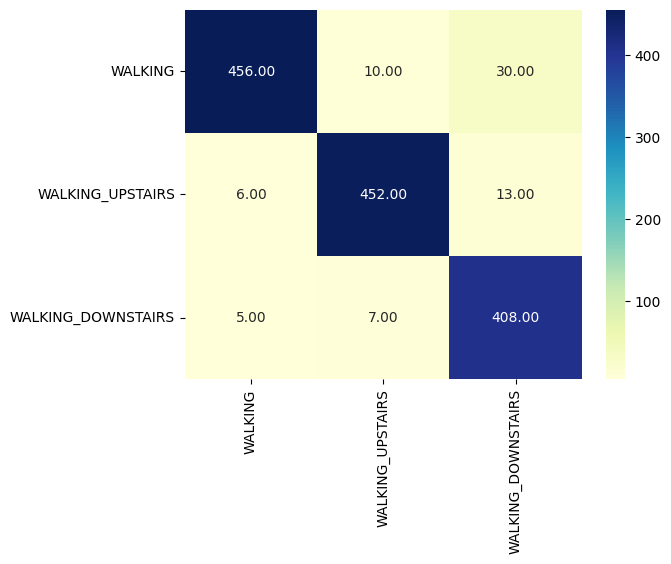

In [60]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [61]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_25 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_25 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_26 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_26 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_27 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_27 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_28 (GRU)                (None, 128, 128)         

In [62]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 12s 147ms/step - loss: 1.0532 - accuracy: 0.4186 - val_loss: 0.9925 - val_accuracy: 0.5355
Epoch 2/10
26/26 [==============================] - 1s 49ms/step - loss: 0.9319 - accuracy: 0.5498 - val_loss: 0.8582 - val_accuracy: 0.6237
Epoch 3/10
26/26 [==============================] - 1s 46ms/step - loss: 0.8227 - accuracy: 0.6198 - val_loss: 0.5766 - val_accuracy: 0.7515
Epoch 4/10
26/26 [==============================] - 1s 46ms/step - loss: 0.4031 - accuracy: 0.8411 - val_loss: 0.1156 - val_accuracy: 0.9594
Epoch 5/10
26/26 [==============================] - 1s 46ms/step - loss: 0.2212 - accuracy: 0.9339 - val_loss: 0.1737 - val_accuracy: 0.9473
Epoch 6/10
26/26 [==============================] - 1s 46ms/step - loss: 0.1071 - accuracy: 0.9714 - val_loss: 0.0334 - val_accuracy: 0.9919
Epoch 7/10
26/26 [==============================] - 1s 46ms/step - loss: 0.0670 - accuracy: 0.9814 - val_loss: 0.0607 - val_accuracy: 0.9838
Epoch 8/10


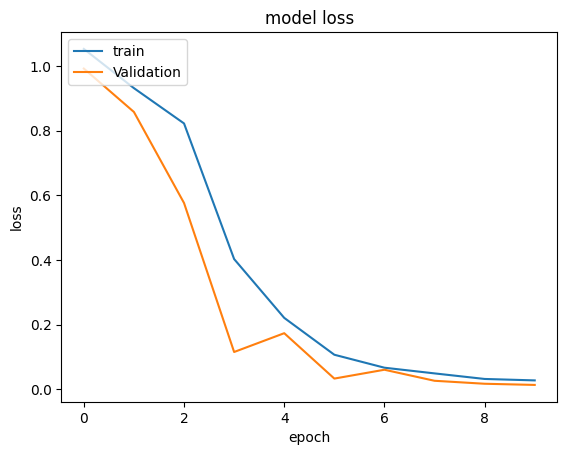

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

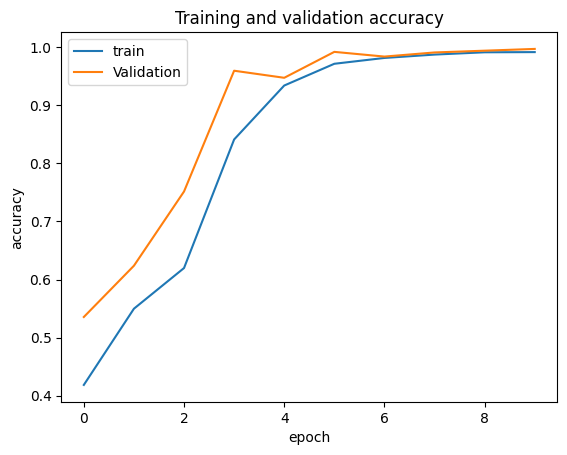

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 13ms/step
[[447  20  29]
 [ 41 410  20]
 [  1   1 418]]
0.9192501802451334
0.918680354501451
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       496
           1       0.95      0.87      0.91       471
           2       0.90      1.00      0.94       420

    accuracy                           0.92      1387
   macro avg       0.92      0.92      0.92      1387
weighted avg       0.92      0.92      0.92      1387



<Axes: >

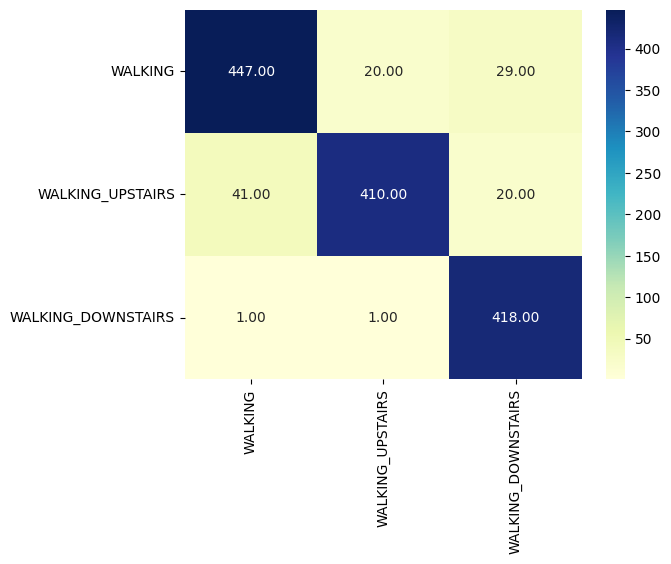

In [65]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')